## The experience replay module: expreplay.py


In [1]:

from collections import deque

import numpy as np


class ExpReplay():
    """
    A generic class for collecting experiences.
    """

    def __init__(self, size):
        """
        Size is the maximum number of collected experiences.
        """
        self.memory = deque(maxlen=size)

    def add(self, exp):
        """
        Add an experience to the queue.
        """
        self.memory.append(exp)

    def sample(self, size):
        """
        Method to sample a collection experiences from the memory.
        Note that this is mostly used in off-policy methods such as Q-learning.
        """
        index = np.random.choice(np.arange(len(self.memory)),
                                 size=size,
                                 replace=False)
        return [self.memory[i] for i in index]

    def get_all(self):
        """Returns all collected experiences"""
        return list(self.memory)

    def clear(self):
        """Empty the memory."""
        self.memory.clear()


## The entire deep reinforcement learning agent: agent.py


In [10]:
from collections import deque

import tensorflow as tf
import numpy as np
from random import shuffle

#from .expreplay import ExpReplay


class Agent():
    """
    The agent class where you should implement the vanilla policy gradient agent.
    """
    
    def __init__(self, tf_session, state_size=(4,), action_size=2,
                 learning_rate=1e-3, gamma=0.99, memory_size=5000):
        """
        The initialization function. Besides saving attributes we also need
        to create the policy network in Tensorflow that later will be used.
        """
        # 1. Specify the network architecture
        self.state_size = state_size          # == env.observation_space.shape[0]
        self.n_outputs = action_size        # outputs the probability of accelerating left and right
        n_hidden = 5                          # it's a simple task, we don't need more than this
        n_inputs = 4
        
        self.tf_sess = tf_session
        self.gamma = gamma
        
        self.replay = ExpReplay(memory_size)
        
        #initializer = tf.contrib.layers.variance_scaling_initializer()
        initializer = tf.variance_scaling_initializer()

        # 2. Build the neural network
        with tf.variable_scope('agent'):
                        
            # Create tf placeholders, i.e. inputs into the neural network graph.
            self.X = tf.placeholder(tf.float32, shape=[None, n_inputs])
            self.reward = tf.placeholder(tf.float32, shape=(None,))
            self.action = tf.placeholder(tf.int32, shape=(None,))
            
            # Create the hidden layers
            hidden = tf.layers.dense(self.X, n_hidden, activation=tf.nn.elu,
                         kernel_initializer=initializer)
            hidden2 = tf.layers.dense(hidden, n_hidden, activation=tf.nn.elu,
                         kernel_initializer=initializer)
            
            logits = tf.layers.dense(hidden2, self.n_outputs)
            
            # create the output
            #self.outputs = tf.layers.dense(hidden, self.n_outputs, activation=tf.nn.softmax,
            #              kernel_initializer=initializer)
            self.outputs = tf.nn.softmax(logits)
            
            
            # 3. Select a random action based on the estimated probabilities TO DO XXXX
            #self.action = tf.multinomial(tf.log(self.outputs), num_samples=2)   
        
            # define the cost function (cross entropy) and compute the gradients:
            cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=tf.one_hot(self.action, depth=self.n_outputs), 
                                                                    logits=logits)
            
            # Create the loss. We need to multiply the reward with the
            # log-probability of the selected actions.
            loss = tf.reduce_mean(self.reward * cross_entropy)

            # Create the optimizer to minimize the loss
            self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)

            #pass

        tf_session.run(tf.global_variables_initializer())
        #saver = tf.train.Saver()

    """
    take_action() that samples the action from the policy network. 
    Run the training and see that it works and acts randomly.
    """
    def take_action(self, state):
        """
        Given the current state, sample an action from the policy network.
        Return a the index of the action [0..N).
        """
        action_pred = self.tf_sess.run(self.outputs, 
                                        feed_dict={self.X: [state]})[0]
        action = np.random.choice(range(self.n_outputs), p=action_pred)
        
        #action = np.random.choice(range(self.action_size))
        return action

    """
    record_action() that just saves a taken action and its reward
    """
    def record_action(self, state0, action, reward, state1, done):
        """
        Record an action taken by the action and the associated reward
        and next state. This will later be used for traning.
        """
        self.replay.add((action, reward, state0))
                
        #pass

    """
    train_agent() that takes the experiences (states, actions, and rewards) 
    collected in record_action() and sends them through the network to compute 
    and optimize the loss.

    """
    def train_agent(self):
        """
        Train the policy network using the collected experiences during the
        episode(s).
        """
        # Retrieve collected experiences from memory
        collected_experiences = self.replay.get_all()
        
        # Refresh the memory
        self.replay.clear()    # XXXX
        
        actions = [h[0] for h in collected_experiences]
        rewards = [h[1] for h in collected_experiences]
        states = [h[2] for h in collected_experiences]

        # Discount and normalize rewards
        rewards = self.discount_rewards_and_normalize(rewards)

        # Shuffle for better learning
        #shuffle(collected_experiences)

        # Feed the experiences through the network with rewards to compute and
        # minimize the loss.
        output = self.tf_sess.run(self.optimizer, 
                                  feed_dict={self.action: actions,
                                             self.reward: rewards, 
                                             self.X: states})
        #pass

    """
    We need to compute the total discounted rewards,
    given the raw rewards, and to normalize the results across multiple episodes:
    """
    def discount_rewards(self, rewards, discount_rate):
        
        # Given the rewards for an epsiode discount them by gamma.
        discounted_rewards = np.zeros(len(rewards))
        cumulative_rewards = 0
        
        for step in reversed(range(len(rewards))):
            cumulative_rewards = rewards[step] + cumulative_rewards * discount_rate
            discounted_rewards[step] = cumulative_rewards
        return discounted_rewards
    
    def discount_rewards_and_normalize(self, rewards):
        # since we are sending them into the neural network they should
        # have a zero mean and unit variance.
        dis_rewards = self.discount_rewards(rewards, self.gamma)
        
        reward_mean = dis_rewards.mean()
        reward_std = dis_rewards.std()
        
        # Return the new discounted and normalized rewards.
        return (dis_rewards - reward_mean)/reward_std 
                
        # pass

## The entrypoint of the program with the training loop : main.py


1 30.0 30 0
2 22.0 22 30.0
3 35.0 35 26.0
4 9.0 9 29.0
5 13.0 13 24.0
6 33.0 33 21.8
7 19.0 19 23.666666666666668
8 28.0 28 23.0
9 37.0 37 23.625
10 11.0 11 25.11111111111111
11 21.0 21 23.7
12 10.0 10 23.454545454545453
13 15.0 15 22.333333333333332
14 13.0 13 21.76923076923077
15 16.0 16 21.142857142857142
16 33.0 33 20.8
17 26.0 26 21.5625
18 49.0 49 21.823529411764707
19 27.0 27 23.333333333333332
20 23.0 23 23.526315789473685
21 66.0 66 23.5
22 25.0 25 25.523809523809526
23 35.0 35 25.5
24 17.0 17 25.91304347826087
25 21.0 21 25.541666666666668
26 47.0 47 25.36
27 13.0 13 26.192307692307693
28 22.0 22 25.703703703703702
29 34.0 34 25.571428571428573
30 15.0 15 25.862068965517242
31 11.0 11 25.5
32 13.0 13 25.032258064516128
33 63.0 63 24.65625
34 73.0 73 25.818181818181817
35 12.0 12 27.205882352941178
36 35.0 35 26.771428571428572
37 49.0 49 27.0
38 12.0 12 27.594594594594593
39 18.0 18 27.18421052631579
40 83.0 83 26.94871794871795
41 52.0 52 28.35
42 16.0 16 28.926829268292682


408 167.0 167 66.93
409 94.0 94 68.29
410 65.0 65 69.05
411 78.0 78 69.1
412 286.0 286 68.9
413 12.0 12 71.07
414 130.0 130 70.67
415 181.0 181 71.71
416 114.0 114 72.45
417 49.0 49 72.93
418 80.0 80 73.14
419 55.0 55 73.67
420 56.0 56 73.56
421 50.0 50 73.95
422 68.0 68 73.76
423 86.0 86 73.83
424 135.0 135 72.62
425 40.0 40 73.26
426 114.0 114 73.36
427 38.0 38 73.49
428 87.0 87 73.55
429 58.0 58 74.15
430 21.0 21 74.46
431 31.0 31 73.69
432 27.0 27 73.84
433 100.0 100 73.6
434 148.0 148 74.13
435 25.0 25 74.64
436 60.0 60 74.53
437 44.0 44 74.26
438 66.0 66 73.89
439 82.0 82 74.29
440 159.0 159 74.55
441 56.0 56 75.12
442 157.0 157 74.67
443 61.0 61 76.08
444 26.0 26 76.17
445 53.0 53 76.03
446 96.0 96 76.13
447 36.0 36 76.29
448 29.0 29 75.03
449 79.0 79 73.77
450 62.0 62 72.82
451 62.0 62 72.93
452 35.0 35 73.14
453 78.0 78 72.02
454 92.0 92 71.91
455 43.0 43 72.5
456 68.0 68 72.18
457 82.0 82 72.49
458 59.0 59 73.04
459 60.0 60 72.98
460 84.0 84 73.44
461 306.0 306 73.92
462 48.0

819 229.0 229 247.85
820 228.0 228 247.83
821 100.0 100 248.27
822 179.0 179 247.91
823 93.0 93 248.05
824 326.0 326 245.69
825 369.0 369 246.21
826 181.0 181 248.15
827 500.0 500 245.71
828 232.0 232 249.22
829 416.0 416 249.38
830 211.0 211 250.59
831 127.0 127 249.42
832 364.0 364 248.13
833 473.0 473 249.92
834 500.0 500 253.05
835 251.0 251 255.74
836 378.0 378 256.87
837 289.0 289 258.59
838 212.0 212 257.13
839 404.0 404 257.41
840 208.0 208 259.37
841 243.0 243 259.17
842 231.0 231 257.91
843 223.0 223 258.15
844 183.0 183 258.08
845 277.0 277 256.48
846 277.0 277 256.28
847 236.0 236 256.37
848 237.0 237 256.88
849 199.0 199 257.19
850 428.0 428 258.41
851 259.0 259 259.4
852 500.0 500 260.23
853 216.0 216 263.03
854 156.0 156 263.72
855 213.0 213 263.52
856 201.0 201 263.58
857 237.0 237 262.49
858 290.0 290 262.46
859 151.0 151 263.97
860 196.0 196 261.61
861 358.0 358 263.16
862 251.0 251 266.2
863 123.0 123 266.9
864 257.0 257 263.95
865 410.0 410 263.66
866 277.0 277 264.

1205 316.0 316 331.85
1206 325.0 325 331.83
1207 355.0 355 332.0
1208 435.0 435 334.13
1209 355.0 355 336.4
1210 112.0 112 336.4
1211 134.0 134 332.52
1212 178.0 178 331.35
1213 449.0 449 329.62
1214 459.0 459 330.29
1215 461.0 461 333.03
1216 475.0 475 334.01
1217 308.0 308 335.65
1218 419.0 419 335.21
1219 218.0 218 334.62
1220 425.0 425 334.2
1221 500.0 500 335.58
1222 327.0 327 338.99
1223 336.0 336 339.19
1224 134.0 134 340.09
1225 109.0 109 336.43
1226 500.0 500 332.52
1227 374.0 374 332.52
1228 341.0 341 334.0
1229 94.0 94 334.76
1230 475.0 475 332.0
1231 500.0 500 331.75
1232 421.0 421 335.55
1233 353.0 353 335.09
1234 500.0 500 335.31
1235 385.0 385 337.84
1236 378.0 378 336.69
1237 490.0 490 335.93
1238 500.0 500 337.78
1239 228.0 228 339.8
1240 402.0 402 337.08
1241 416.0 416 336.1
1242 285.0 285 337.85
1243 207.0 207 337.55
1244 250.0 250 334.83
1245 287.0 287 333.2
1246 500.0 500 332.31
1247 341.0 341 332.31
1248 495.0 495 333.44
1249 335.0 335 333.39
1250 500.0 500 333.94

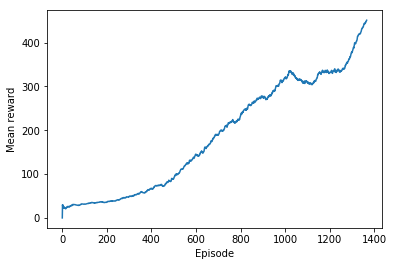

In [11]:
from time import time

import gym
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

#from .agent import Agent


def env_solved(history):
    """
    Checks if the agent has solved the CartPole-v1 environment.
    """
    return history[-1]['mean_reward'] >= 450


def main(nbr_eps, tf_session, render_every=100):
    """Main training loop of the RL agent."""

    # Create the environment
    env = gym.make('CartPole-v1')
    env.seed(1)

    # Create the agent
    agent = Agent(tf_session,
                  state_size=env.observation_space.shape,
                  action_size=env.action_space.n,
                  learning_rate=1e-2,
                  gamma=0.99)
    history = []

    for ep in range(1, nbr_eps + 1):
        # Start an episode of training
        state0 = env.reset()
        done = False
        step = 0
        total_reward = 0
        tt = time()

        # Take actions until the end of the episode
        while not done:

            # Render every nth episode
            if ep % render_every == 0:
                env.render()

            # Ask agent for action
            action = agent.take_action(state0)

            # Apply action to the environment. Get reward and the new state.
            state1, reward, done, _ = env.step(action)

            # Record the <s, a, r, s'> tuple for later when training.
            agent.record_action(state0, action, reward, state1, done)

            total_reward += reward
            step += 1
            state0 = state1

        # Train the network after each episode
        agent.train_agent()

        # Save information about the episode
        mean_reward = np.mean(np.array([h['reward'] for h in history[-100:]])) \
            if len(history) > 0 else 0
        history.append({
            'ep': ep, 'reward': total_reward, 'steps': step, 'time': time() - tt,
            'mean_reward': mean_reward
        })
        # Print information about the episode
        print(ep, total_reward, step, mean_reward)

        if env_solved(history):
            print('Agent solved the environment in {} episodes!'.format(ep))
            plt.plot([h['mean_reward'] for h in history])
            plt.ylabel('Mean reward')
            plt.xlabel('Episode')
            plt.show()
            break


if __name__ == '__main__':
    tf.reset_default_graph()
    with tf.Session() as tf_session:
        main(3000, tf_session)
        